## Variable that changed a lot

In [1]:
Model_name = "squeezenet"

run_num  = "3"         
# It should match the the name of notebook
tensor_baord_variable = Model_name + '_' + run_num

# The path of the best check point
path = f"CheckPoints/{tensor_baord_variable}"

In [2]:
tensor_baord_variable, path

('squeezenet_3', 'CheckPoints/squeezenet_3')

## Check the working environment

In [3]:
import sys
def is_venv(): return hasattr(sys, 'real_prefix') or sys.base_prefix != sys.prefix

print("sys.base_prefix >> ", sys.base_prefix)
print("sys.prefix >> ", sys.prefix)

print("is_venv():", is_venv())

sys.base_prefix >>  /usr
sys.prefix >>  /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang
is_venv(): True


In [4]:
import os

if os.getenv('VIRTUAL_ENV'):
    print('Using Virtualenv')
else:
    print('Not using Virtualenv')

Using Virtualenv


In [5]:
import sys
import os

print(f'Python Executable: {sys.executable}')
print(f'Python Version: {sys.version}')
print(f'Virtualenv: {os.getenv("VIRTUAL_ENV")}')

Python Executable: /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang/bin/python
Python Version: 3.8.10 (default, May 26 2023, 14:05:08) 
[GCC 9.4.0]
Virtualenv: /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang


## Import libraries

In [6]:
## Import important libraries 

import torch 
from torch import nn 
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

import torchvision
print(torch.__version__)

1.10.0+cu102


In [7]:
# Tune the seed to get the same result for every run for the same parameters
# Remove the randomness in the results 

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Check the availabitlity of GPU

In [8]:
# Chech the nvidia compiler driver
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [9]:
# check if CUDA is available

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda" if train_on_gpu else "cpu")


CUDA is available!  Training on GPU ...


In [10]:
# check the device proparities
torch.cuda.get_device_properties(torch.cuda.current_device())

_CudaDeviceProperties(name='Quadro GV100', major=7, minor=0, total_memory=32505MB, multi_processor_count=80)

## Dataset Pre-processing

In [11]:
import os

In [12]:
# This class is used to apply specific transform on  the data 

class InheritedDataset():
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y, images_path = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y, images_path
    
    def __len__(self):
        return len(self.dataset)

In [13]:
# Transformation or Processing for the dataset 

img_size = 224

trans = transforms.Compose([  transforms.Resize(img_size),
                              transforms.CenterCrop(img_size),
                              transforms.ToTensor(),
                            
 ] )

transNoAugment = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor(),
 ] )

In [14]:
# https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

import torch
from torchvision import datasets
from PIL import Image, ImageOps
from typing import Any # , Callable, cast, Dict, List, Optional, Tuple

class ImageFolderWithPaths(datasets.ImageFolder):
    """
    Custom dataset that includes image file paths. 
    Extends for torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        # print('Here')
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
#        print("Hello")
        # print(traindataset)
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [15]:
# "https://stackoverflow.com/questions/12984426/pil-ioerror-image-file-truncated-with-big-images"

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [16]:
def custom_pil_loader(path: str) -> Image.Image:
    """
    This function is used to fix the orientation of the image based on its EXIF data (Exchangeable Image File Format). 
    It handles cases where the image may have been rotated or flipped based on the device or software used to capture it.
    """
    
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    # with open(path, "rb") as f:
    # print("Second")

    with open(path, "rb") as f:
        img = Image.open(f)
    
        fixed_image = ImageOps.exif_transpose(img)
        return fixed_image.convert("RGB")

In [17]:
import sklearn
from sklearn.model_selection import train_test_split

In [18]:
# Assign the batch size and number of workers

batch_size, num_workers  = 64, 32

In [19]:
# Get the data using torch and convert it to tensors

data_dir = "/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version"

dataset = ImageFolderWithPaths(root = data_dir, loader= custom_pil_loader) # transform = transforms.ToTensor())

traindataset, testdataset = InheritedDataset(dataset,trans), InheritedDataset(dataset,transNoAugment)

num_train = len(dataset)
indices = list(range(num_train))

# Data splitting 
# Split the data into training, validation and testing 

X_train, X_test = train_test_split(indices, test_size=0.3, random_state=42 , stratify = dataset.targets , shuffle = True)
X_test_classes = [dataset.targets[i]  for i in X_test]
X_test_after , X_validation = train_test_split(X_test, test_size=0.5, random_state=42,  stratify = X_test_classes , shuffle = True)



train_data = torch.utils.data.Subset(traindataset, indices=X_train)
val_data   = torch.utils.data.Subset(testdataset, indices=X_validation)
test_data  = torch.utils.data.Subset(testdataset, indices=X_test_after)


print(f'Training Data len is ', len(train_data))
print(f'Validation Data len is ', len(val_data))
print(f'Testing Data len is ', len(test_data))

print()

print(f'DataSet len is' , num_train)
print(f'Training Dataset len is' , len(traindataset))
print(f'Testing Dataset len is' , len(testdataset))

# Prepare the loader of the data

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size , num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers= num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size, num_workers = num_workers)

print()
print(f"train_loader size is {len(train_loader)}")
print(f"val_Loader size is {len(val_loader)}")
print(f"test_Loader  size is {len(test_loader)}")

Training Data len is  5499
Validation Data len is  1179
Testing Data len is  1178

DataSet len is 7856
Training Dataset len is 7856
Testing Dataset len is 7856

train_loader size is 86
val_Loader size is 19
test_Loader  size is 19


In [20]:
# Print the index for the dataset for each class 
print(dataset.class_to_idx)

{'Ain': 0, 'Al': 1, 'Alef': 2, 'Beh': 3, 'Dad': 4, 'Dal': 5, 'Feh': 6, 'Ghain': 7, 'Hah': 8, 'Heh': 9, 'Jeem': 10, 'Kaf': 11, 'Khah': 12, 'Laa': 13, 'Lam': 14, 'Meem': 15, 'Noon': 16, 'Qaf': 17, 'Reh': 18, 'Sad': 19, 'Seen': 20, 'Sheen': 21, 'Tah': 22, 'Teh': 23, 'Teh_Marbuta': 24, 'Thal': 25, 'Theh': 26, 'Waw': 27, 'Yeh': 28, 'Zah': 29, 'Zain': 30}


In [21]:
## Print the classes in the dataset 

dataset.classes

['Ain',
 'Al',
 'Alef',
 'Beh',
 'Dad',
 'Dal',
 'Feh',
 'Ghain',
 'Hah',
 'Heh',
 'Jeem',
 'Kaf',
 'Khah',
 'Laa',
 'Lam',
 'Meem',
 'Noon',
 'Qaf',
 'Reh',
 'Sad',
 'Seen',
 'Sheen',
 'Tah',
 'Teh',
 'Teh_Marbuta',
 'Thal',
 'Theh',
 'Waw',
 'Yeh',
 'Zah',
 'Zain']

In [22]:
from torchvision.datasets import ImageFolder

# Get the list of images and their extensions
image_paths = [path for path, _ in dataset.imgs]
image_extensions = set([path.split('.')[-1].lower() for path in image_paths])

# Print the unique image extensions
print("Image Extensions:", image_extensions)

Image Extensions: {'jpg', 'jpeg'}


### Check corrupted images 

In [23]:
import torch
import torchvision.transforms as transforms

def identify_corrupted_images(loader):
    corrupted_images = []
    
    try:
        for batch in loader:
            _, _, image_paths = batch

            # Check if any image in the batch is corrupted
            for i in range(len(image_paths)):
                image_path = image_paths[i]
                
                from PIL import Image

                def is_image_corrupted(image_path):
                    try:
                        with open(image_path, 'rb') as f:
                            Image.open(f)
                        return False
                    except:
                        return True

                corrupted = is_image_corrupted(image_path)
                if corrupted:
                    print("The image is corrupted.")
                else:
                    pass


                corrupted_images.append(image_path)
    
        return corrupted_images
    except:
        print(loader)
# Loop over the train loader and identify corrupted images
corrupted_train_images = identify_corrupted_images(train_loader)

# # Loop over the validation loader and identify corrupted images
# corrupted_val_images = identify_corrupted_images(val_loader)

# # Loop over the test loader and identify corrupted images
# corrupted_test_images = identify_corrupted_images(test_loader)


In [24]:
# def is_image_truncated(image_path):
#     try:
#         # Open the image to check if it's valid
#         with Image.open(image_path) as image:
#             # Check if any operations can be performed on the image without errors
#             image.verify()
#         return False
#     except (OSError, SyntaxError):
#         return True

In [25]:
# import os
# from PIL import Image

# # Specify the root directory containing the subdirectories with images
# root_dir = '/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version'

# # Iterate over the subdirectories and files
# for subdir, dirs, files in os.walk(root_dir):

#     for file in files:
#         # Check if the file is an image (you can add more image file extensions if needed)
#         if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
            
#             # Create the image path
#             image_path = os.path.join(subdir, file)

#             # Open the image using PIL

#             image = Image.open(image_path)

#             if is_image_truncated(image_path):
#                 print(image_path)
#                 print('The image file is truncated.')
#             else:
#                 print(image_path)
#                 # print('The image file is not truncated.')

### Check the images

In [26]:
import matplotlib.pyplot as plt

In [27]:
examples = iter(test_loader)
example_data, example_targets, paths = examples.next()

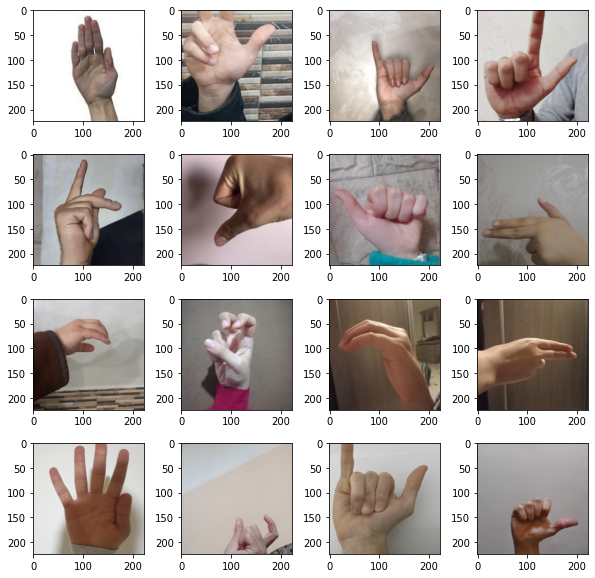

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(example_data[i].permute(1, 2, 0))
    # ax.axis('off')  # Turn off axis labels for each subplot

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust the spacing between subplots

plt.show()

### Add Tensorboard

In [29]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [30]:
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f"runs/{tensor_baord_variable}")

In [31]:
############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image(
    f'images_{tensor_baord_variable}', img_grid)
writer.close()

In [32]:
%tensorboard --logdir="runs/{tensor_baord_variable}"

UsageError: Line magic function `%tensorboard` not found.


## Data visulization

In [33]:
from collections import Counter
import numpy as np

In [34]:
training_Targets = [] 
validation_Targets = [] 
testing_Targets = [] 

for i in X_train: 
  training_Targets.append(dataset.targets[i])

for i in X_validation: 
  validation_Targets.append(dataset.targets[i])

for i in X_test_after: 
  testing_Targets.append(dataset.targets[i])

In [35]:
C_training   = Counter(training_Targets) 
C_validation = Counter(validation_Targets)
C_testing    = Counter(testing_Targets)

In [36]:
dataset.classes

['Ain',
 'Al',
 'Alef',
 'Beh',
 'Dad',
 'Dal',
 'Feh',
 'Ghain',
 'Hah',
 'Heh',
 'Jeem',
 'Kaf',
 'Khah',
 'Laa',
 'Lam',
 'Meem',
 'Noon',
 'Qaf',
 'Reh',
 'Sad',
 'Seen',
 'Sheen',
 'Tah',
 'Teh',
 'Teh_Marbuta',
 'Thal',
 'Theh',
 'Waw',
 'Yeh',
 'Zah',
 'Zain']

#### Training dataset

Text(0.5, 0, 'Label')

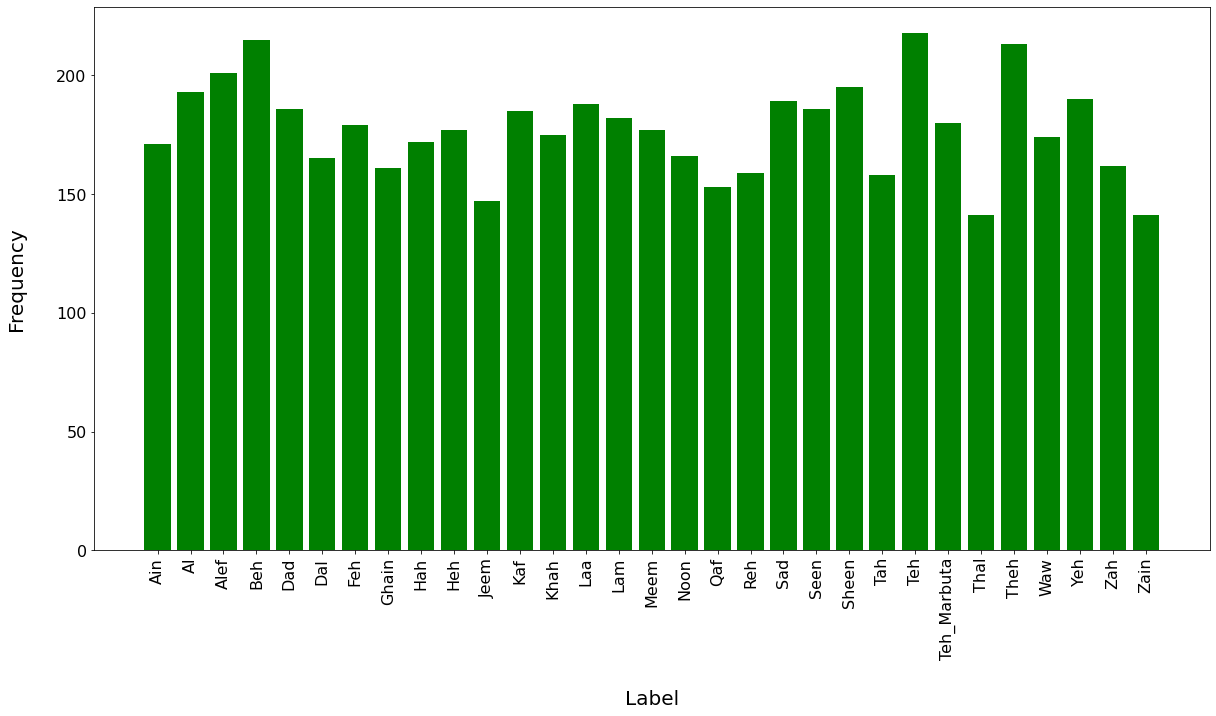

In [37]:
plt.figure(figsize=(20,10))
plt.bar(C_training.keys(), height=C_training.values(), color="green")

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);

plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

#### Validation dataset

Text(0.5, 0, 'Label')

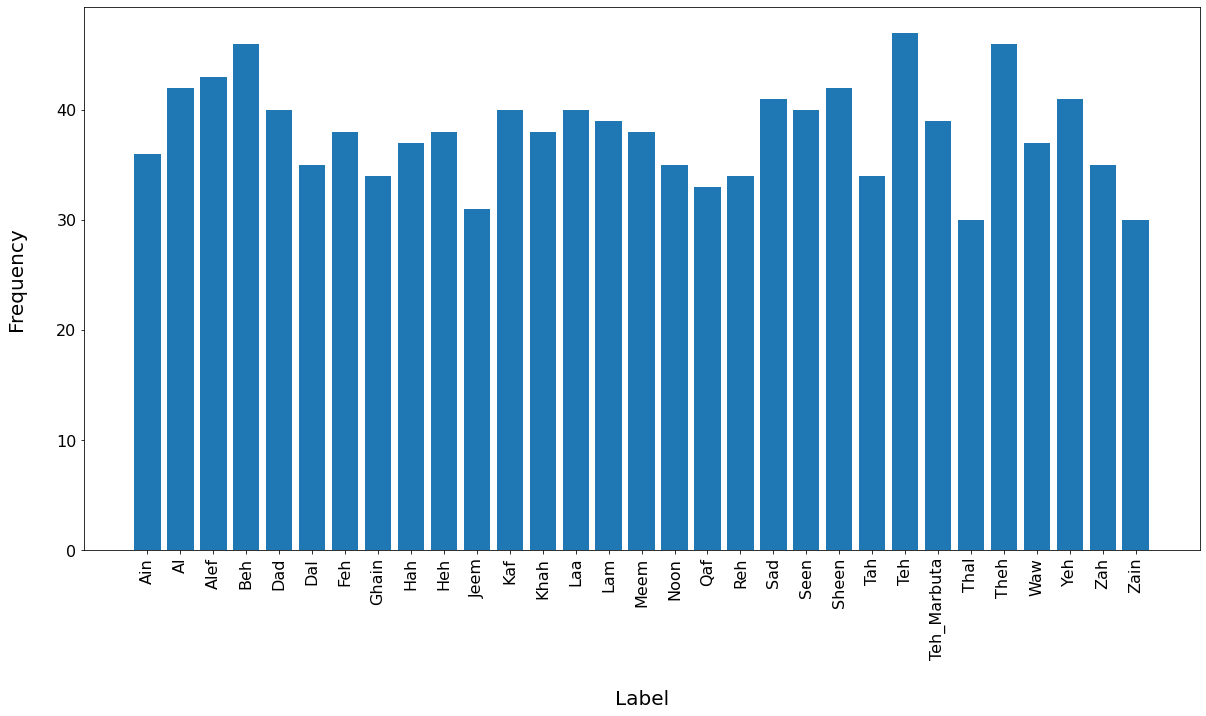

In [38]:
plt.figure(figsize=(20,10))
plt.bar(C_validation.keys(), height=C_validation.values())

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);
plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

#### Testing Dataset

Text(0.5, 0, 'Label')

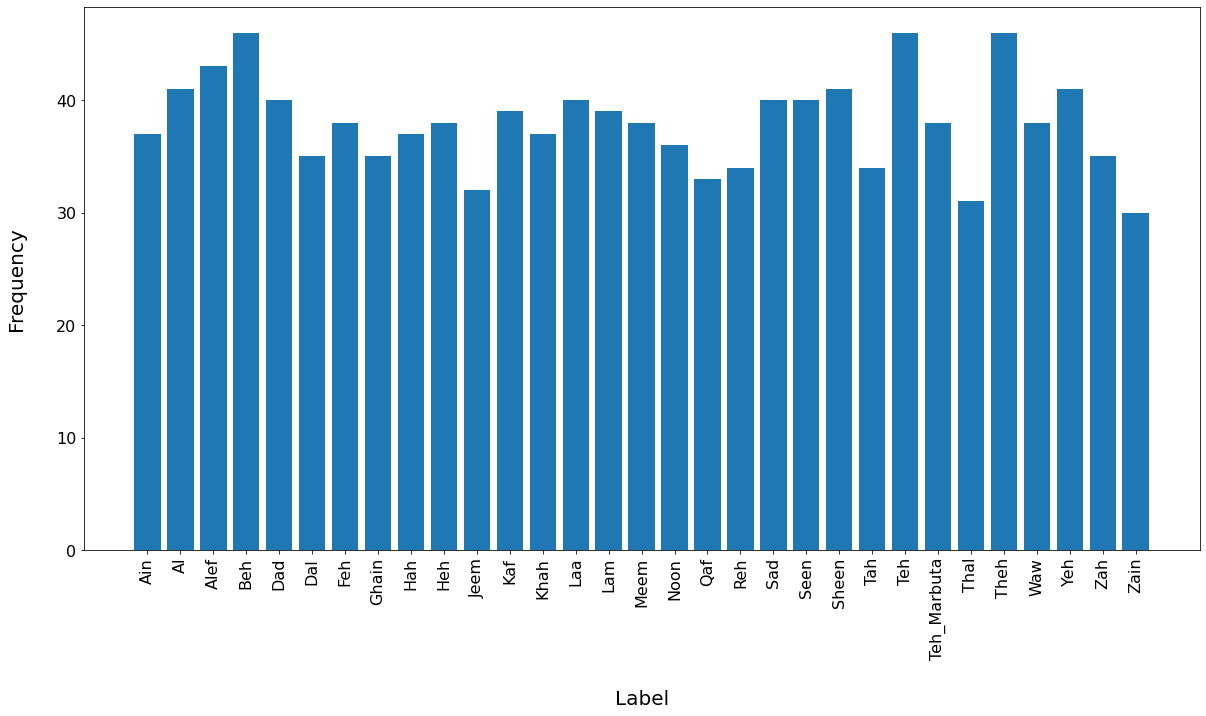

In [39]:
plt.figure(figsize=(20,10))

plt.bar(C_testing.keys(), height=C_testing.values())

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);
plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

## Model Defenition

In [40]:
import torchvision.models as models
import torch.nn.functional as F


In [41]:
class Model(nn.Module):

    def __init__(self, in_channels=3, num_class =31 ):
        super(Model, self).__init__()

        self.model = models.squeezenet1_0(pretrained=True)
        
        for param in self.model.parameters():
            param.requires_grad = False

        # change the last conv2d layer
        self.model.classifier._modules["1"] = nn.Conv2d(512, num_class, kernel_size=(1, 1))
        # change the internal num_classes variable rather than redefining the forward pass
        self.model.num_classes = num_class


    def forward(self, x):
        return self.model(x)


In [42]:
# Move the model to the device

model = Model()
model.to(device)

Model(
  (model): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_

### Check the gradient of layers of ResNet-18

In [43]:
for param in model.parameters():
    if not param.requires_grad:
        print("Freezing found on the layers")

Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found

In [44]:
pytorch_total_params = sum(p.numel() for p in model.parameters())

pytorch_total_params


751327

In [45]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params


15903

## Define a Loss function and optimizer

In [46]:
# Define my Loss 

loss = nn.CrossEntropyLoss()

# Define my optimizer 

params = model.parameters()
optimzer = optim.SGD(params, lr=0.01)

optimzer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

## Model Training & Validation

In [47]:
from tqdm import tqdm 

### Model training & Validation

In [48]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 10

In [49]:
# import EarlyStopping
from pytorchtools import EarlyStopping

In [50]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

In [51]:
All_end_eopch_training_loss = []
All_end_eopch_validation_loss = []

In [52]:
n_epochs = 300
accuracy, best_Acc = 0.0, 0.0, 
print_each_steps = 100
prev_avg_loss = float('inf')
 

# Batch calculations
n_total_steps = len(train_loader)
running_correct, running_loss_val, running_correct_val, training_running_loss = 0, 0.0, 0.0, 0.0

for epoch in range(n_epochs):  # loop over the dataset multiple times
    
    model.train()

    losses_training = [] 
    accuracies_tarining = []

    ###################
    # train the model #
    ###################  
    
    for i, batch in tqdm(enumerate(train_loader, 1),"Epoch # is {}".format(epoch) ,total = len(train_loader),position=0, leave=False):

        inputs, labels, _ = batch 

        # import pdb; pdb.set_trace()
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs) # logits / scores 


        logits = logits.to(device)

        # Calculate loss
        J = loss(logits,labels)

        #  re-initlize gradiants, calculate gradients, update the weights
        optimzer.zero_grad(); J.backward() ; optimzer.step()

        # 
        training_running_loss += J.item()
        # _, predicted = torch.max(logits.data, 1)
        # running_correct += (predicted == labels).sum().item()


        losses_training.append(J.item())

        running_correct += labels.eq(logits.detach().argmax(dim=1)).float().mean()
        accuracies_tarining.append(labels.eq(logits.detach().argmax(dim=1)).float().mean())
    
        # Print some information each "print_each_steps" steps 

        if i%print_each_steps ==0:
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i}/{n_total_steps}], Loss: {J.item():.8f}')
            ############## TENSORBOARD ########################
            writer.add_scalar('Batch_training_loss', training_running_loss / print_each_steps, epoch * n_total_steps + i)
            running_accuracy = running_correct / print_each_steps  # 
            writer.add_scalar('Batch_training_accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            training_running_loss = 0.0
            ###################################################

    # End epoch calculations 
    End_Eopch_Training_Loss = torch.tensor(losses_training).float().mean()
    End_Eopch_Training_Acc  = torch.tensor(accuracies_tarining).float().mean()
  
    
    # Add training loss and training accuracy each epoch 
    writer.add_scalar('End_epoch_training_loss', End_Eopch_Training_Loss.item(),epoch)
    writer.add_scalar('End_epoch_training_accuracy', End_Eopch_Training_Acc.item(),epoch)


    print()
    print(f'Epoch {epoch + 1}/{n_epochs},  Step [{i}/{n_total_steps}]', end = ', ')
    print(f'Avg training loss: { End_Eopch_Training_Loss.item() : .8f}', end = ', ')
    print(f'Avg training accuracy : {End_Eopch_Training_Acc.item() : .8%}')
    print()


    
    
    ######################    
    # validate the model #
    ######################
        
    losses_validation = [] 
    accuracies_validation = []
  

    model.eval()
  
    with torch.no_grad():
        
        for batch in tqdm(val_loader, total = len(val_loader), position=0, leave=False):

            inputs, labels, _ = batch 

            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs) # logits / scores 

            logits = logits.to(device)

            J = loss(logits,labels)


            losses_validation.append(J.item())

            running_loss_val += J.item()
            losses_validation.append(J.item())


            running_correct = labels.eq(logits.detach().argmax(dim=1)).float().mean()
            accuracies_validation.append(labels.eq(logits.detach().argmax(dim=1)).float().mean())
      
        current_loss  = torch.tensor(losses_validation).float().mean()
        current_Accuracy = torch.tensor(accuracies_validation).float().mean()
                  

        writer.add_scalar('End epoch, Validation loss', running_loss_val / len(val_loader), epoch)
        running_accuracy = running_correct / len(val_loader) 
        writer.add_scalar('End epoch, Validation accuracy', running_accuracy, epoch )
        

        print()  
        print(f'Epoch {epoch + 1}', end = ', ')
        print(f'Avg validation loss: {current_loss :.8f}', end = ', ')
        print(f'Avg validation accuracy : {current_Accuracy :.8%}')
        print()



        if current_loss < prev_avg_loss:

            prev_avg_loss = current_loss

            print()
            print('The best validation Loss is ', prev_avg_loss.item())
            print('The Current Accuracy of validation is ', current_Accuracy.item() * 100)
            print()

            torch.save(model.state_dict(), path)
      
        if current_Accuracy > best_Acc :

            best_Acc = current_Accuracy

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(current_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break           
            
        # Add training loss and training accuracy each epoch 
        writer.add_scalar('End_epoch_validation_loss', torch.tensor(losses_validation).float().mean().item(),epoch)
        writer.add_scalar('End_epoch_validation_accuracy', torch.tensor(accuracies_validation).float().mean().item(),epoch)

    # End epoch, training dataset
    All_end_eopch_validation_loss.append(torch.tensor(losses_validation).float().mean().item())
    
    # End epoch, training dataset
    All_end_eopch_training_loss.append(End_Eopch_Training_Loss.item())  
    
    writer.add_scalars('Traning_Validation', {'EOP_training loss':End_Eopch_Training_Loss.item(),
                                            'EOP_Validation loss':torch.tensor(losses_validation).float().mean().item()},
                                             epoch)

    running_loss_val = 0.0 
    running_correct_val = 0
    


Epoch 1/300,  Step [86/86], Avg training loss:  3.01507187, Avg training accuracy :  17.19704568%




Epoch 1, Avg validation loss: 2.52460599, Avg validation accuracy : 28.63669693%


The best validation Loss is  2.5246059894561768
The Current Accuracy of validation is  28.636696934700012

Validation loss decreased (inf --> 2.524606).  Saving model ...



Epoch 2/300,  Step [86/86], Avg training loss:  2.24342442, Avg training accuracy :  35.56119204%




Epoch 2, Avg validation loss: 1.99083066, Avg validation accuracy : 41.22807086%


The best validation Loss is  1.990830659866333
The Current Accuracy of validation is  41.228070855140686

Validation loss decreased (2.524606 --> 1.990831).  Saving model ...



Epoch 3/300,  Step [86/86], Avg training loss:  1.82238472, Avg training accuracy :  46.99540734%




Epoch 3, Avg validation loss: 1.70317817, Avg validation accuracy : 49.57358837%


The best validation Loss is  1.7031781673431396
The Current Accuracy of validation is  49.573588371276855

Validation loss decreased (1.990831 --> 1.703178).  Saving model ...



Epoch 4/300,  Step [86/86], Avg training loss:  1.59714186, Avg training accuracy :  53.63156796%




Epoch 4, Avg validation loss: 1.54638469, Avg validation accuracy : 53.76766324%


The best validation Loss is  1.5463846921920776
The Current Accuracy of validation is  53.76766324043274

Validation loss decreased (1.703178 --> 1.546385).  Saving model ...



Epoch 5/300,  Step [86/86], Avg training loss:  1.44666660, Avg training accuracy :  58.17064047%




Epoch 5, Avg validation loss: 1.43965054, Avg validation accuracy : 57.55969882%


The best validation Loss is  1.439650535583496
The Current Accuracy of validation is  57.559698820114136

Validation loss decreased (1.546385 --> 1.439651).  Saving model ...



Epoch 6/300,  Step [86/86], Avg training loss:  1.35296619, Avg training accuracy :  61.04435325%




Epoch 6, Avg validation loss: 1.35167742, Avg validation accuracy : 61.98830605%


The best validation Loss is  1.351677417755127
The Current Accuracy of validation is  61.98830604553223

Validation loss decreased (1.439651 --> 1.351677).  Saving model ...



Epoch 7/300,  Step [86/86], Avg training loss:  1.27213037, Avg training accuracy :  62.55388856%




Epoch 7, Avg validation loss: 1.29103816, Avg validation accuracy : 62.94468641%


The best validation Loss is  1.291038155555725
The Current Accuracy of validation is  62.94468641281128

Validation loss decreased (1.351677 --> 1.291038).  Saving model ...



Epoch 8/300,  Step [86/86], Avg training loss:  1.21394920, Avg training accuracy :  64.71748948%




Epoch 8, Avg validation loss: 1.24704564, Avg validation accuracy : 63.46856952%


The best validation Loss is  1.247045636177063
The Current Accuracy of validation is  63.46856951713562

Validation loss decreased (1.291038 --> 1.247046).  Saving model ...



Epoch 9/300,  Step [86/86], Avg training loss:  1.15638828, Avg training accuracy :  66.48292542%




Epoch 9, Avg validation loss: 1.21845973, Avg validation accuracy : 64.50718641%


The best validation Loss is  1.2184597253799438
The Current Accuracy of validation is  64.50718641281128

Validation loss decreased (1.247046 --> 1.218460).  Saving model ...



Epoch 10/300,  Step [86/86], Avg training loss:  1.11819339, Avg training accuracy :  67.36856699%




Epoch 10, Avg validation loss: 1.17835796, Avg validation accuracy : 66.42909050%


The best validation Loss is  1.1783579587936401
The Current Accuracy of validation is  66.42909049987793

Validation loss decreased (1.218460 --> 1.178358).  Saving model ...



Epoch 11/300,  Step [86/86], Avg training loss:  1.07612979, Avg training accuracy :  68.82359982%




Epoch 11, Avg validation loss: 1.14805698, Avg validation accuracy : 66.70625806%


The best validation Loss is  1.148056983947754
The Current Accuracy of validation is  66.70625805854797

Validation loss decreased (1.178358 --> 1.148057).  Saving model ...



Epoch 12/300,  Step [86/86], Avg training loss:  1.04139960, Avg training accuracy :  69.93495822%




Epoch 12, Avg validation loss: 1.12047601, Avg validation accuracy : 67.99159050%


The best validation Loss is  1.1204760074615479
The Current Accuracy of validation is  67.99159049987793

Validation loss decreased (1.148057 --> 1.120476).  Saving model ...



Epoch 13/300,  Step [86/86], Avg training loss:  1.02186656, Avg training accuracy :  70.29680014%




Epoch 13, Avg validation loss: 1.09816563, Avg validation accuracy : 68.07382703%


The best validation Loss is  1.0981656312942505
The Current Accuracy of validation is  68.07382702827454

Validation loss decreased (1.120476 --> 1.098166).  Saving model ...



Epoch 14/300,  Step [86/86], Avg training loss:  0.98706037, Avg training accuracy :  71.22185230%




Epoch 14, Avg validation loss: 1.08458996, Avg validation accuracy : 68.12561154%


The best validation Loss is  1.084589958190918
The Current Accuracy of validation is  68.1256115436554

Validation loss decreased (1.098166 --> 1.084590).  Saving model ...



Epoch 15/300,  Step [86/86], Avg training loss:  0.96737039, Avg training accuracy :  71.89563513%




Epoch 15, Avg validation loss: 1.06306493, Avg validation accuracy : 69.38961744%


The best validation Loss is  1.0630649328231812
The Current Accuracy of validation is  69.38961744308472

Validation loss decreased (1.084590 --> 1.063065).  Saving model ...



Epoch 16/300,  Step [86/86], Avg training loss:  0.94990540, Avg training accuracy :  73.19022417%




Epoch 16, Avg validation loss: 1.05308115, Avg validation accuracy : 69.06067133%


The best validation Loss is  1.0530811548233032
The Current Accuracy of validation is  69.06067132949829

Validation loss decreased (1.063065 --> 1.053081).  Saving model ...



Epoch 17/300,  Step [86/86], Avg training loss:  0.93548179, Avg training accuracy :  72.86010385%




Epoch 17, Avg validation loss: 1.04163003, Avg validation accuracy : 69.58454847%


The best validation Loss is  1.0416300296783447
The Current Accuracy of validation is  69.58454847335815

Validation loss decreased (1.053081 --> 1.041630).  Saving model ...



Epoch 18/300,  Step [86/86], Avg training loss:  0.91165084, Avg training accuracy :  73.40516448%




Epoch 18, Avg validation loss: 1.02861834, Avg validation accuracy : 69.42007542%


The best validation Loss is  1.028618335723877
The Current Accuracy of validation is  69.42007541656494

Validation loss decreased (1.041630 --> 1.028618).  Saving model ...



Epoch 19/300,  Step [86/86], Avg training loss:  0.89327025, Avg training accuracy :  73.97454977%




Epoch 19, Avg validation loss: 1.01851499, Avg validation accuracy : 69.74902153%


The best validation Loss is  1.0185149908065796
The Current Accuracy of validation is  69.74902153015137

Validation loss decreased (1.028618 --> 1.018515).  Saving model ...



Epoch 20/300,  Step [86/86], Avg training loss:  0.88536745, Avg training accuracy :  74.24246073%




Epoch 20, Avg validation loss: 1.00972843, Avg validation accuracy : 70.24244666%


The best validation Loss is  1.0097284317016602
The Current Accuracy of validation is  70.24244666099548

Validation loss decreased (1.018515 --> 1.009728).  Saving model ...



Epoch 21/300,  Step [86/86], Avg training loss:  0.85884821, Avg training accuracy :  75.20693541%




Epoch 21, Avg validation loss: 1.00236464, Avg validation accuracy : 70.65362930%


The best validation Loss is  1.0023646354675293
The Current Accuracy of validation is  70.65362930297852

Validation loss decreased (1.009728 --> 1.002365).  Saving model ...



Epoch 22/300,  Step [86/86], Avg training loss:  0.85007769, Avg training accuracy :  75.29469728%




Epoch 22, Avg validation loss: 0.98675728, Avg validation accuracy : 70.45869827%


The best validation Loss is  0.9867572784423828
The Current Accuracy of validation is  70.45869827270508

Validation loss decreased (1.002365 --> 0.986757).  Saving model ...



Epoch 23/300,  Step [86/86], Avg training loss:  0.83580834, Avg training accuracy :  75.09946823%




Epoch 23, Avg validation loss: 0.98147362, Avg validation accuracy : 70.81810236%


The best validation Loss is  0.9814736247062683
The Current Accuracy of validation is  70.81810235977173

Validation loss decreased (0.986757 --> 0.981474).  Saving model ...



Epoch 24/300,  Step [86/86], Avg training loss:  0.82215935, Avg training accuracy :  76.18803978%




Epoch 24, Avg validation loss: 0.97274560, Avg validation accuracy : 71.14704847%


The best validation Loss is  0.9727455973625183
The Current Accuracy of validation is  71.14704847335815

Validation loss decreased (0.981474 --> 0.972746).  Saving model ...



Epoch 25/300,  Step [86/86], Avg training loss:  0.81294918, Avg training accuracy :  76.75126791%




Epoch 25, Avg validation loss: 0.96545237, Avg validation accuracy : 71.72271013%


The best validation Loss is  0.9654523730278015
The Current Accuracy of validation is  71.72271013259888

Validation loss decreased (0.972746 --> 0.965452).  Saving model ...



Epoch 26/300,  Step [86/86], Avg training loss:  0.80124551, Avg training accuracy :  76.66042447%




Epoch 26, Avg validation loss: 0.95622957, Avg validation accuracy : 71.31152153%


The best validation Loss is  0.956229567527771
The Current Accuracy of validation is  71.31152153015137

Validation loss decreased (0.965452 --> 0.956230).  Saving model ...



Epoch 27/300,  Step [86/86], Avg training loss:  0.79846281, Avg training accuracy :  76.86182261%




Epoch 27, Avg validation loss: 0.95121896, Avg validation accuracy : 72.10343480%


The best validation Loss is  0.9512189626693726
The Current Accuracy of validation is  72.10343480110168

Validation loss decreased (0.956230 --> 0.951219).  Saving model ...



Epoch 28/300,  Step [86/86], Avg training loss:  0.77640539, Avg training accuracy :  77.66431570%




Epoch 28, Avg validation loss: 0.96188647, Avg validation accuracy : 71.03435397%

EarlyStopping counter: 1 out of 10



Epoch 29/300,  Step [86/86], Avg training loss:  0.76898736, Avg training accuracy :  77.66124010%




Epoch 29, Avg validation loss: 0.93784833, Avg validation accuracy : 72.82224894%


The best validation Loss is  0.9378483295440674
The Current Accuracy of validation is  72.82224893569946

Validation loss decreased (0.951219 --> 0.937848).  Saving model ...



Epoch 30/300,  Step [86/86], Avg training loss:  0.76668221, Avg training accuracy :  77.53406167%




Epoch 30, Avg validation loss: 0.93967170, Avg validation accuracy : 72.65777588%

EarlyStopping counter: 1 out of 10



Epoch 31/300,  Step [86/86], Avg training loss:  0.75726789, Avg training accuracy :  78.24417949%




Epoch 31, Avg validation loss: 0.93086714, Avg validation accuracy : 72.54507542%


The best validation Loss is  0.9308671355247498
The Current Accuracy of validation is  72.54507541656494

Validation loss decreased (0.937848 --> 0.930867).  Saving model ...



Epoch 32/300,  Step [86/86], Avg training loss:  0.74773657, Avg training accuracy :  78.33963633%




Epoch 32, Avg validation loss: 0.92582130, Avg validation accuracy : 72.79178500%


The best validation Loss is  0.9258213043212891
The Current Accuracy of validation is  72.79178500175476

Validation loss decreased (0.930867 --> 0.925821).  Saving model ...



Epoch 33/300,  Step [86/86], Avg training loss:  0.74275649, Avg training accuracy :  78.55304480%




Epoch 33, Avg validation loss: 0.92711508, Avg validation accuracy : 73.17251563%

EarlyStopping counter: 1 out of 10



Epoch 34/300,  Step [86/86], Avg training loss:  0.72570783, Avg training accuracy :  79.17693257%




Epoch 34, Avg validation loss: 0.92049831, Avg validation accuracy : 72.54507542%


The best validation Loss is  0.9204983115196228
The Current Accuracy of validation is  72.54507541656494

Validation loss decreased (0.925821 --> 0.920498).  Saving model ...



Epoch 35/300,  Step [86/86], Avg training loss:  0.72001588, Avg training accuracy :  79.06176448%




Epoch 35, Avg validation loss: 0.92443478, Avg validation accuracy : 72.62731194%

EarlyStopping counter: 1 out of 10



Epoch 36/300,  Step [86/86], Avg training loss:  0.72154385, Avg training accuracy :  78.89978290%




Epoch 36, Avg validation loss: 0.91498947, Avg validation accuracy : 73.56238365%


The best validation Loss is  0.9149894714355469
The Current Accuracy of validation is  73.5623836517334

Validation loss decreased (0.920498 --> 0.914989).  Saving model ...



Epoch 37/300,  Step [86/86], Avg training loss:  0.72225112, Avg training accuracy :  78.75751257%




Epoch 37, Avg validation loss: 0.91020507, Avg validation accuracy : 73.28521013%


The best validation Loss is  0.910205066204071
The Current Accuracy of validation is  73.28521013259888

Validation loss decreased (0.914989 --> 0.910205).  Saving model ...



Epoch 38/300,  Step [86/86], Avg training loss:  0.70800078, Avg training accuracy :  79.04512882%




Epoch 38, Avg validation loss: 0.91484112, Avg validation accuracy : 73.12073708%

EarlyStopping counter: 1 out of 10



Epoch 39/300,  Step [86/86], Avg training loss:  0.70504582, Avg training accuracy :  79.75370884%




Epoch 39, Avg validation loss: 0.90654933, Avg validation accuracy : 73.71771336%


The best validation Loss is  0.906549334526062
The Current Accuracy of validation is  73.71771335601807

Validation loss decreased (0.910205 --> 0.906549).  Saving model ...



Epoch 40/300,  Step [86/86], Avg training loss:  0.69128698, Avg training accuracy :  80.08227944%




Epoch 40, Avg validation loss: 0.90577918, Avg validation accuracy : 73.20297360%


The best validation Loss is  0.9057791829109192
The Current Accuracy of validation is  73.20297360420227

Validation loss decreased (0.906549 --> 0.905779).  Saving model ...



Epoch 41/300,  Step [86/86], Avg training loss:  0.70085078, Avg training accuracy :  79.53260541%




Epoch 41, Avg validation loss: 0.89439774, Avg validation accuracy : 73.36744666%


The best validation Loss is  0.8943977355957031
The Current Accuracy of validation is  73.36744666099548

Validation loss decreased (0.905779 --> 0.894398).  Saving model ...



Epoch 42/300,  Step [86/86], Avg training loss:  0.68078399, Avg training accuracy :  79.95048165%




Epoch 42, Avg validation loss: 0.90450841, Avg validation accuracy : 72.43238091%

EarlyStopping counter: 1 out of 10



Epoch 43/300,  Step [86/86], Avg training loss:  0.68038839, Avg training accuracy :  80.21993637%




Epoch 43, Avg validation loss: 0.89355135, Avg validation accuracy : 73.86086583%


The best validation Loss is  0.8935513496398926
The Current Accuracy of validation is  73.86086583137512

Validation loss decreased (0.894398 --> 0.893551).  Saving model ...



Epoch 44/300,  Step [86/86], Avg training loss:  0.66934389, Avg training accuracy :  80.97562790%




Epoch 44, Avg validation loss: 0.88794345, Avg validation accuracy : 73.33698869%


The best validation Loss is  0.8879434466362
The Current Accuracy of validation is  73.33698868751526

Validation loss decreased (0.893551 --> 0.887943).  Saving model ...



Epoch 45/300,  Step [86/86], Avg training loss:  0.67174339, Avg training accuracy :  80.42594790%




Epoch 45, Avg validation loss: 0.90090299, Avg validation accuracy : 73.09027910%

EarlyStopping counter: 1 out of 10



Epoch 46/300,  Step [86/86], Avg training loss:  0.65981233, Avg training accuracy :  80.93774319%




Epoch 46, Avg validation loss: 0.88063222, Avg validation accuracy : 74.27204847%


The best validation Loss is  0.880632221698761
The Current Accuracy of validation is  74.27204847335815

Validation loss decreased (0.887943 --> 0.880632).  Saving model ...



Epoch 47/300,  Step [86/86], Avg training loss:  0.65765089, Avg training accuracy :  81.19056225%




Epoch 47, Avg validation loss: 0.88626021, Avg validation accuracy : 73.86086583%

EarlyStopping counter: 1 out of 10



Epoch 48/300,  Step [86/86], Avg training loss:  0.66072667, Avg training accuracy :  80.84382415%




Epoch 48, Avg validation loss: 0.88754332, Avg validation accuracy : 74.02533889%

EarlyStopping counter: 2 out of 10



Epoch 49/300,  Step [86/86], Avg training loss:  0.65330118, Avg training accuracy :  80.91341853%




Epoch 49, Avg validation loss: 0.88706106, Avg validation accuracy : 73.66593480%

EarlyStopping counter: 3 out of 10



Epoch 50/300,  Step [86/86], Avg training loss:  0.64559478, Avg training accuracy :  81.00887537%




Epoch 50, Avg validation loss: 0.87426013, Avg validation accuracy : 73.94310236%


The best validation Loss is  0.8742601275444031
The Current Accuracy of validation is  73.94310235977173

Validation loss decreased (0.880632 --> 0.874260).  Saving model ...



Epoch 51/300,  Step [86/86], Avg training loss:  0.64837414, Avg training accuracy :  80.95591068%




Epoch 51, Avg validation loss: 0.87962151, Avg validation accuracy : 73.44968319%

EarlyStopping counter: 1 out of 10



Epoch 52/300,  Step [86/86], Avg training loss:  0.63960671, Avg training accuracy :  81.82646036%




Epoch 52, Avg validation loss: 0.87662619, Avg validation accuracy : 74.22027588%

EarlyStopping counter: 2 out of 10



Epoch 53/300,  Step [86/86], Avg training loss:  0.63686013, Avg training accuracy :  81.46309257%




Epoch 53, Avg validation loss: 0.87154156, Avg validation accuracy : 74.71369505%


The best validation Loss is  0.8715415596961975
The Current Accuracy of validation is  74.71369504928589

Validation loss decreased (0.874260 --> 0.871542).  Saving model ...



Epoch 54/300,  Step [86/86], Avg training loss:  0.63065243, Avg training accuracy :  81.53114915%




Epoch 54, Avg validation loss: 0.87971336, Avg validation accuracy : 73.77862930%

EarlyStopping counter: 1 out of 10



Epoch 55/300,  Step [86/86], Avg training loss:  0.62686378, Avg training accuracy :  82.13533163%




Epoch 55, Avg validation loss: 0.87569577, Avg validation accuracy : 74.46698546%

EarlyStopping counter: 2 out of 10



Epoch 56/300,  Step [86/86], Avg training loss:  0.62622511, Avg training accuracy :  82.15042949%




Epoch 56, Avg validation loss: 0.87018466, Avg validation accuracy : 74.32382703%


The best validation Loss is  0.8701846599578857
The Current Accuracy of validation is  74.32382702827454

Validation loss decreased (0.871542 --> 0.870185).  Saving model ...



Epoch 57/300,  Step [86/86], Avg training loss:  0.62562746, Avg training accuracy :  81.80676103%




Epoch 57, Avg validation loss: 0.87614602, Avg validation accuracy : 74.32382703%

EarlyStopping counter: 1 out of 10



Epoch 58/300,  Step [86/86], Avg training loss:  0.61869109, Avg training accuracy :  81.57364726%




Epoch 58, Avg validation loss: 0.86950815, Avg validation accuracy : 74.27204847%


The best validation Loss is  0.8695081472396851
The Current Accuracy of validation is  74.27204847335815

Validation loss decreased (0.870185 --> 0.869508).  Saving model ...



Epoch 59/300,  Step [86/86], Avg training loss:  0.62585580, Avg training accuracy :  81.81138039%




Epoch 59, Avg validation loss: 0.86801571, Avg validation accuracy : 74.13803935%


The best validation Loss is  0.868015706539154
The Current Accuracy of validation is  74.13803935050964

Validation loss decreased (0.869508 --> 0.868016).  Saving model ...



Epoch 60/300,  Step [86/86], Avg training loss:  0.61663133, Avg training accuracy :  81.88251257%




Epoch 60, Avg validation loss: 0.86833745, Avg validation accuracy : 73.74817133%

EarlyStopping counter: 1 out of 10



Epoch 61/300,  Step [86/86], Avg training loss:  0.60073370, Avg training accuracy :  82.75306225%




Epoch 61, Avg validation loss: 0.85817057, Avg validation accuracy : 74.57054257%


The best validation Loss is  0.8581705689430237
The Current Accuracy of validation is  74.57054257392883

Validation loss decreased (0.868016 --> 0.858171).  Saving model ...



Epoch 62/300,  Step [86/86], Avg training loss:  0.60262871, Avg training accuracy :  82.44265914%




Epoch 62, Avg validation loss: 0.85913217, Avg validation accuracy : 75.04264712%

EarlyStopping counter: 1 out of 10



Epoch 63/300,  Step [86/86], Avg training loss:  0.60026491, Avg training accuracy :  82.35644102%




Epoch 63, Avg validation loss: 0.86230367, Avg validation accuracy : 74.38474894%

EarlyStopping counter: 2 out of 10



Epoch 64/300,  Step [86/86], Avg training loss:  0.59370035, Avg training accuracy :  83.04376006%




Epoch 64, Avg validation loss: 0.85949063, Avg validation accuracy : 74.32382703%

EarlyStopping counter: 3 out of 10



Epoch 65/300,  Step [86/86], Avg training loss:  0.59245694, Avg training accuracy :  82.79248476%




Epoch 65, Avg validation loss: 0.86031371, Avg validation accuracy : 74.76547360%

EarlyStopping counter: 4 out of 10



Epoch 66/300,  Step [86/86], Avg training loss:  0.59273309, Avg training accuracy :  82.64405131%




Epoch 66, Avg validation loss: 0.85549122, Avg validation accuracy : 74.79593158%


The best validation Loss is  0.8554912209510803
The Current Accuracy of validation is  74.7959315776825

Validation loss decreased (0.858171 --> 0.855491).  Saving model ...



Epoch 67/300,  Step [86/86], Avg training loss:  0.58594179, Avg training accuracy :  83.28457475%




Epoch 67, Avg validation loss: 0.85198480, Avg validation accuracy : 74.43652153%


The best validation Loss is  0.8519847989082336
The Current Accuracy of validation is  74.43652153015137

Validation loss decreased (0.855491 --> 0.851985).  Saving model ...



Epoch 68/300,  Step [86/86], Avg training loss:  0.58102703, Avg training accuracy :  83.38896036%




Epoch 68, Avg validation loss: 0.85028577, Avg validation accuracy : 74.84771013%


The best validation Loss is  0.8502857685089111
The Current Accuracy of validation is  74.84771013259888

Validation loss decreased (0.851985 --> 0.850286).  Saving model ...



Epoch 69/300,  Step [86/86], Avg training loss:  0.58208323, Avg training accuracy :  83.15431476%




Epoch 69, Avg validation loss: 0.85979128, Avg validation accuracy : 73.91264439%

EarlyStopping counter: 1 out of 10



Epoch 70/300,  Step [86/86], Avg training loss:  0.58609402, Avg training accuracy :  82.39431381%




Epoch 70, Avg validation loss: 0.85433328, Avg validation accuracy : 74.65277910%

EarlyStopping counter: 2 out of 10



Epoch 71/300,  Step [86/86], Avg training loss:  0.57651746, Avg training accuracy :  83.15431476%




Epoch 71, Avg validation loss: 0.85760540, Avg validation accuracy : 74.57054257%

EarlyStopping counter: 3 out of 10



Epoch 72/300,  Step [86/86], Avg training loss:  0.56121355, Avg training accuracy :  83.68274570%




Epoch 72, Avg validation loss: 0.84974450, Avg validation accuracy : 74.54922199%


The best validation Loss is  0.8497444987297058
The Current Accuracy of validation is  74.54922199249268

Validation loss decreased (0.850286 --> 0.849744).  Saving model ...



Epoch 73/300,  Step [86/86], Avg training loss:  0.57671136, Avg training accuracy :  82.70625472%




Epoch 73, Avg validation loss: 0.84635973, Avg validation accuracy : 75.17665625%


The best validation Loss is  0.8463597297668457
The Current Accuracy of validation is  75.1766562461853

Validation loss decreased (0.849744 --> 0.846360).  Saving model ...



Epoch 74/300,  Step [86/86], Avg training loss:  0.56789964, Avg training accuracy :  83.44346881%




Epoch 74, Avg validation loss: 0.85622877, Avg validation accuracy : 74.65277910%

EarlyStopping counter: 1 out of 10



Epoch 75/300,  Step [86/86], Avg training loss:  0.56357789, Avg training accuracy :  83.71754289%




Epoch 75, Avg validation loss: 0.84064275, Avg validation accuracy : 74.96040463%


The best validation Loss is  0.8406427502632141
The Current Accuracy of validation is  74.96040463447571

Validation loss decreased (0.846360 --> 0.840643).  Saving model ...



Epoch 76/300,  Step [86/86], Avg training loss:  0.55916017, Avg training accuracy :  83.84934068%




Epoch 76, Avg validation loss: 0.85142094, Avg validation accuracy : 74.81725216%

EarlyStopping counter: 1 out of 10



Epoch 77/300,  Step [86/86], Avg training loss:  0.56169194, Avg training accuracy :  83.37388039%




Epoch 77, Avg validation loss: 0.85057563, Avg validation accuracy : 74.48830605%

EarlyStopping counter: 2 out of 10



Epoch 78/300,  Step [86/86], Avg training loss:  0.56456095, Avg training accuracy :  83.15585852%




Epoch 78, Avg validation loss: 0.85312033, Avg validation accuracy : 74.32382703%

EarlyStopping counter: 3 out of 10



Epoch 79/300,  Step [86/86], Avg training loss:  0.54545265, Avg training accuracy :  84.42611694%




Epoch 79, Avg validation loss: 0.85742831, Avg validation accuracy : 74.35428500%

EarlyStopping counter: 4 out of 10



Epoch 80/300,  Step [86/86], Avg training loss:  0.55602098, Avg training accuracy :  83.75080228%




Epoch 80, Avg validation loss: 0.84777528, Avg validation accuracy : 75.31067133%

EarlyStopping counter: 5 out of 10



Epoch 81/300,  Step [86/86], Avg training loss:  0.54881346, Avg training accuracy :  84.20963883%




Epoch 81, Avg validation loss: 0.84388161, Avg validation accuracy : 75.28935671%

EarlyStopping counter: 6 out of 10



Epoch 82/300,  Step [86/86], Avg training loss:  0.54378551, Avg training accuracy :  84.15666819%




Epoch 82, Avg validation loss: 0.84247398, Avg validation accuracy : 74.73501563%

EarlyStopping counter: 7 out of 10



Epoch 83/300,  Step [86/86], Avg training loss:  0.54840302, Avg training accuracy :  84.06428695%




Epoch 83, Avg validation loss: 0.84818727, Avg validation accuracy : 75.37159324%

EarlyStopping counter: 8 out of 10



Epoch 84/300,  Step [86/86], Avg training loss:  0.54919302, Avg training accuracy :  83.73878598%




Epoch 84, Avg validation loss: 0.84041995, Avg validation accuracy : 76.47112608%


The best validation Loss is  0.8404199481010437
The Current Accuracy of validation is  76.47112607955933

Validation loss decreased (0.840643 --> 0.840420).  Saving model ...



Epoch 85/300,  Step [86/86], Avg training loss:  0.54875374, Avg training accuracy :  83.90384912%




Epoch 85, Avg validation loss: 0.85218138, Avg validation accuracy : 74.35428500%

EarlyStopping counter: 1 out of 10



Epoch 86/300,  Step [86/86], Avg training loss:  0.54334009, Avg training accuracy :  83.87058973%




Epoch 86, Avg validation loss: 0.83909106, Avg validation accuracy : 74.81725216%


The best validation Loss is  0.8390910625457764
The Current Accuracy of validation is  74.81725215911865

Validation loss decreased (0.840420 --> 0.839091).  Saving model ...



Epoch 87/300,  Step [86/86], Avg training loss:  0.54006374, Avg training accuracy :  84.44582820%




Epoch 87, Avg validation loss: 0.84785593, Avg validation accuracy : 74.51875806%

EarlyStopping counter: 1 out of 10



Epoch 88/300,  Step [86/86], Avg training loss:  0.53370190, Avg training accuracy :  84.35652256%




Epoch 88, Avg validation loss: 0.83886307, Avg validation accuracy : 74.65277910%


The best validation Loss is  0.8388630747795105
The Current Accuracy of validation is  74.65277910232544

Validation loss decreased (0.839091 --> 0.838863).  Saving model ...



Epoch 89/300,  Step [86/86], Avg training loss:  0.52334893, Avg training accuracy :  84.53820944%




Epoch 89, Avg validation loss: 0.84736592, Avg validation accuracy : 75.39290786%

EarlyStopping counter: 1 out of 10



Epoch 90/300,  Step [86/86], Avg training loss:  0.54470944, Avg training accuracy :  84.06428695%




Epoch 90, Avg validation loss: 0.83783448, Avg validation accuracy : 75.06396174%


The best validation Loss is  0.8378344774246216
The Current Accuracy of validation is  75.06396174430847

Validation loss decreased (0.838863 --> 0.837834).  Saving model ...



Epoch 91/300,  Step [86/86], Avg training loss:  0.52872360, Avg training accuracy :  84.73498225%




Epoch 91, Avg validation loss: 0.83244884, Avg validation accuracy : 75.14619827%


The best validation Loss is  0.8324488401412964
The Current Accuracy of validation is  75.14619827270508

Validation loss decreased (0.837834 --> 0.832449).  Saving model ...



Epoch 92/300,  Step [86/86], Avg training loss:  0.52808475, Avg training accuracy :  84.66385007%




Epoch 92, Avg validation loss: 0.83233863, Avg validation accuracy : 75.53606629%


The best validation Loss is  0.8323386311531067
The Current Accuracy of validation is  75.53606629371643

Validation loss decreased (0.832449 --> 0.832339).  Saving model ...



Epoch 93/300,  Step [86/86], Avg training loss:  0.52058136, Avg training accuracy :  85.32253504%




Epoch 93, Avg validation loss: 0.84487677, Avg validation accuracy : 74.27204847%

EarlyStopping counter: 1 out of 10



Epoch 94/300,  Step [86/86], Avg training loss:  0.52336109, Avg training accuracy :  84.68663692%




Epoch 94, Avg validation loss: 0.84521192, Avg validation accuracy : 74.15935397%

EarlyStopping counter: 2 out of 10



Epoch 95/300,  Step [86/86], Avg training loss:  0.52820289, Avg training accuracy :  84.30048227%




Epoch 95, Avg validation loss: 0.84447169, Avg validation accuracy : 74.07711744%

EarlyStopping counter: 3 out of 10



Epoch 96/300,  Step [86/86], Avg training loss:  0.52235556, Avg training accuracy :  84.48832035%




Epoch 96, Avg validation loss: 0.84529352, Avg validation accuracy : 74.81725216%

EarlyStopping counter: 4 out of 10



Epoch 97/300,  Step [86/86], Avg training loss:  0.50741518, Avg training accuracy :  85.72378755%




Epoch 97, Avg validation loss: 0.84020638, Avg validation accuracy : 75.42336583%

EarlyStopping counter: 5 out of 10



Epoch 98/300,  Step [86/86], Avg training loss:  0.51786280, Avg training accuracy :  84.99396443%




Epoch 98, Avg validation loss: 0.83821511, Avg validation accuracy : 74.65277910%

EarlyStopping counter: 6 out of 10



Epoch 99/300,  Step [86/86], Avg training loss:  0.51320380, Avg training accuracy :  84.66385007%




Epoch 99, Avg validation loss: 0.83428854, Avg validation accuracy : 74.89948869%

EarlyStopping counter: 7 out of 10



Epoch 100/300,  Step [86/86], Avg training loss:  0.50886464, Avg training accuracy :  85.06664038%




Epoch 100, Avg validation loss: 0.83487099, Avg validation accuracy : 75.06396174%

EarlyStopping counter: 8 out of 10



Epoch 101/300,  Step [86/86], Avg training loss:  0.50283498, Avg training accuracy :  85.26495099%




Epoch 101, Avg validation loss: 0.83683956, Avg validation accuracy : 75.06396174%

EarlyStopping counter: 9 out of 10



Epoch 102/300,  Step [86/86], Avg training loss:  0.50569856, Avg training accuracy :  85.44971347%




Epoch 102, Avg validation loss: 0.84469634, Avg validation accuracy : 75.17665625%

EarlyStopping counter: 10 out of 10
Early stopping


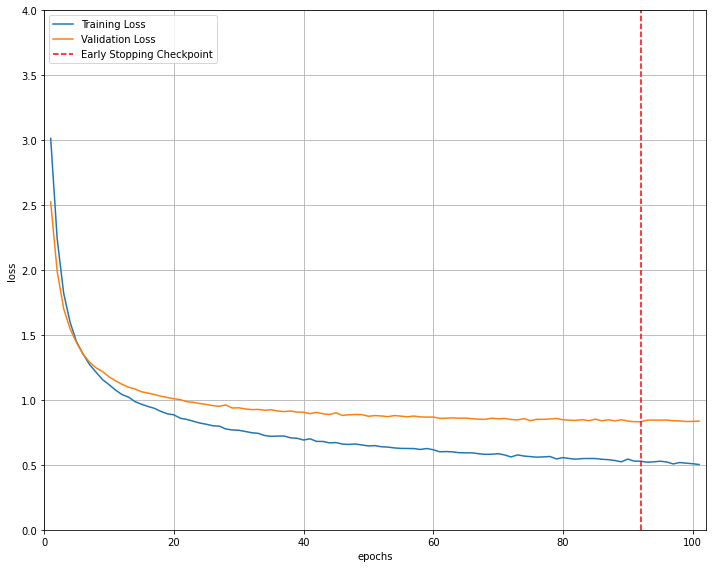

In [53]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(All_end_eopch_training_loss)+1),All_end_eopch_training_loss, label='Training Loss')
plt.plot(range(1,len(All_end_eopch_validation_loss)+1),All_end_eopch_validation_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = All_end_eopch_validation_loss.index(min(All_end_eopch_validation_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 4) # consistent scale
plt.xlim(0, len(All_end_eopch_training_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

## Model testing

In [54]:
model = Model().to(device)
model.load_state_dict(torch.load(path))

print("path >> ", path)

path >>  CheckPoints/squeezenet_3


### Testing loop

In [55]:
fault_images = []
count = 0 

true = []
pred = []
pred_wrong = []
true_wrong = []
image = [] 

In [56]:
losses_testing = [] 
accuracies_testing = []
labels_list = [] 
logits_list = [] 

model.eval()

index = 0

with torch.no_grad():

    for i,batch in tqdm(enumerate(test_loader, 1), total = len(test_loader), position=0, leave=False):
        
        
        inputs, labels, paths = batch

        inputs = inputs.to(device)
    
        labels = labels.to(device)

        logits = model(inputs) # logits / scores 

        labels_list.append(labels.cpu().detach().numpy())
        logits_list.append(logits.cpu().detach().argmax(dim=1).numpy())

        predicted_labels = logits.cpu().detach().argmax(dim=1).numpy() # list of indices
        logits = logits.to(device)

        J = loss(logits,labels)


        loss_every_batch = J.item()
        losses_testing.append(loss_every_batch)
        

        acc = labels.eq(logits.detach().argmax(dim=1)).float().mean()
        check_it = (logits.detach().argmax(dim=1) != labels).nonzero()

     
        if len(check_it) != 0:
            idicies = check_it.cpu().numpy()
            
            for idx in idicies:
                for ele in idx:
                    fault_images.append([inputs[ele], predicted_labels[ele], labels[ele].item(), paths[ele]])
                    count += 1

        accuracies_testing.append(acc)      
        
        
        
        for i in range(len(predicted_labels)):
            pred.append(predicted_labels[i])
            true.append(labels[i].item())
            if(predicted_labels[i]!=labels[i]):
                pred_wrong.append(predicted_labels[i])
                true_wrong.append(labels[i].item())

        writer.add_scalar("Batch, Testing, loss",loss_every_batch, i)
        writer.add_scalar("Batch, Testing, accuracy",acc, i)

    print()
    print(f'Avg testing loss: {torch.tensor(losses_testing).mean():.5f}', end = ', ')
    print(f'Avg testing accuracy : {torch.tensor(accuracies_testing).float().mean()*100}%')
    print()


Avg testing loss: 0.84322, Avg testing accuracy : 72.4380111694336%



In [57]:
from sklearn import metrics


In [58]:
def performance_matrix(true,pred, type_met):
    precision = metrics.precision_score(true,pred,average=type_met)
    recall = metrics.recall_score(true,pred,average=type_met)
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average=type_met)
    print('Confusion Matrix:\n',metrics.confusion_matrix(true, pred))
    print('Precision: {} \n Recall: {}, \n Accuracy: {}: ,\n f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [59]:
performance_matrix(true,pred, 'macro')

Confusion Matrix:
 [[28  0  0  0  1  2  0  0  4  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 29  0  1  0  0  0  0  0  0  0  0  0  1  4  0  1  0  0  0  0  4  0  0
   0  0  0  0  0  1  0]
 [ 0  0 39  1  1  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0  0  2  0  0  0  1  2  1  0  2  0  0  0  0  0  7
   0  0  2  0  0  0  0]
 [ 0  0  0  0 33  0  0  0  0  0  1  0  0  0  0  0  0  0  0  2  1  0  0  0
   0  0  0  0  3  0  0]
 [ 0  0  0  0  1 25  0  0  1  0  0  0  1  0  0  0  0  0  3  0  0  0  0  0
   0  4  0  0  0  0  0]
 [ 0  0  0  2  4  0 21  0  0  5  0  0  0  0  0  1  0  1  0  0  0  0  0  0
   1  0  0  1  2  0  0]
 [ 0  0  2  0  0  0  0 28  1  0  0  0  3  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 33  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  4  0  0 27  0  0  0  0  0  0  0  3  0  1  0  0  0  0
   3  0  0  0  0  0  0]
 

In [60]:
performance_matrix(true,pred, 'micro')

Confusion Matrix:
 [[28  0  0  0  1  2  0  0  4  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 29  0  1  0  0  0  0  0  0  0  0  0  1  4  0  1  0  0  0  0  4  0  0
   0  0  0  0  0  1  0]
 [ 0  0 39  1  1  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0  0  2  0  0  0  1  2  1  0  2  0  0  0  0  0  7
   0  0  2  0  0  0  0]
 [ 0  0  0  0 33  0  0  0  0  0  1  0  0  0  0  0  0  0  0  2  1  0  0  0
   0  0  0  0  3  0  0]
 [ 0  0  0  0  1 25  0  0  1  0  0  0  1  0  0  0  0  0  3  0  0  0  0  0
   0  4  0  0  0  0  0]
 [ 0  0  0  2  4  0 21  0  0  5  0  0  0  0  0  1  0  1  0  0  0  0  0  0
   1  0  0  1  2  0  0]
 [ 0  0  2  0  0  0  0 28  1  0  0  0  3  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 33  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  4  0  0 27  0  0  0  0  0  0  0  3  0  1  0  0  0  0
   3  0  0  0  0  0  0]
 

In [61]:
performance_matrix(true,pred, None)

Confusion Matrix:
 [[28  0  0  0  1  2  0  0  4  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 29  0  1  0  0  0  0  0  0  0  0  0  1  4  0  1  0  0  0  0  4  0  0
   0  0  0  0  0  1  0]
 [ 0  0 39  1  1  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0  0  2  0  0  0  1  2  1  0  2  0  0  0  0  0  7
   0  0  2  0  0  0  0]
 [ 0  0  0  0 33  0  0  0  0  0  1  0  0  0  0  0  0  0  0  2  1  0  0  0
   0  0  0  0  3  0  0]
 [ 0  0  0  0  1 25  0  0  1  0  0  0  1  0  0  0  0  0  3  0  0  0  0  0
   0  4  0  0  0  0  0]
 [ 0  0  0  2  4  0 21  0  0  5  0  0  0  0  0  1  0  1  0  0  0  0  0  0
   1  0  0  1  2  0  0]
 [ 0  0  2  0  0  0  0 28  1  0  0  0  3  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 33  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  4  0  0 27  0  0  0  0  0  0  0  3  0  1  0  0  0  0
   3  0  0  0  0  0  0]
 

In [62]:
performance_matrix(true,pred, "weighted")

Confusion Matrix:
 [[28  0  0  0  1  2  0  0  4  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 29  0  1  0  0  0  0  0  0  0  0  0  1  4  0  1  0  0  0  0  4  0  0
   0  0  0  0  0  1  0]
 [ 0  0 39  1  1  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0  0  2  0  0  0  1  2  1  0  2  0  0  0  0  0  7
   0  0  2  0  0  0  0]
 [ 0  0  0  0 33  0  0  0  0  0  1  0  0  0  0  0  0  0  0  2  1  0  0  0
   0  0  0  0  3  0  0]
 [ 0  0  0  0  1 25  0  0  1  0  0  0  1  0  0  0  0  0  3  0  0  0  0  0
   0  4  0  0  0  0  0]
 [ 0  0  0  2  4  0 21  0  0  5  0  0  0  0  0  1  0  1  0  0  0  0  0  0
   1  0  0  1  2  0  0]
 [ 0  0  2  0  0  0  0 28  1  0  0  0  3  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 33  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  4  0  0 27  0  0  0  0  0  0  0  3  0  1  0  0  0  0
   3  0  0  0  0  0  0]
 

In [63]:
count

322

In [64]:
len(fault_images)
# , predicted_labels[ele], labels[ele].item()

322

In [65]:
traindataset.dataset.class_to_idx ;
idx2label = {idx:val for val, idx in traindataset.dataset.class_to_idx.items()}

In [66]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [67]:
!ls

 ArSL_Journal_alexnet_SGD_001_freezing.ipynb	 CM_alexnet_3
 ArSL_Journal_alexnet_SGD_001.ipynb		 CM_alexnet_4
 ArSL_Journal_alexnet_SGD_01_freezing.ipynb	 CM_Resnet_18_1
 ArSL_Journal_alexnet_SGD_01.ipynb		 CM_Resnet_18_2
 ArSL_Journal_alexnet_VGG16_001_freezing.ipynb	 CM_Resnet_18_3
 ArSL_Journal_alexnet_VGG16_001.ipynb		 CM_squeezenet_1
 ArSL_Journal_alexnet_VGG16_01_freezing.ipynb	 CM_squeezenet_2
 ArSL_Journal_alexnet_VGG16_01.ipynb		 CM_VGG16_1
 ArSL_Journal_Resnet18_01_freezing.ipynb	 CM_VGG16_2
 ArSL_Journal_Resnet18_01.ipynb			 CM_VGG16_4
 ArSL_Journal_Resnet18_SGD_001.ipynb		'Final Data Version'
 ArSL_Journal_squeezenet_001.ipynb		 images
 ArSL_Journal_squeezenet_01_freezing.ipynb	 loss_plot.png
 ArSL_Journal_squeezenet_01.ipynb		 __pycache__
 checkpoint.pt					 pytorchtools.py
 CheckPoints					 requirements.txt
 CM_alexnet_1					 runs


### Print fault images

In [68]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images):
    name_image = f"P_{idx2label[fault_images[i][1]]}_T_{idx2label[fault_images[i][2]]}_{i}.png"
    print(name_image)
    print(fault_images[i][3])
    # plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    # plt.savefig("images/" + name_image, format="png", bbox_inches='tight') # , dpi=400
    # plt.title(name_image)


P_Lam_T_Al_0.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Al/Al_127.jpg
P_Sad_T_Dad_1.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Dad/Dad_98.jpg
P_Waw_T_Jeem_2.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Jeem/Jeem_30.jpg
P_Jeem_T_Thal_3.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Thal/thal_169.jpg
P_Tah_T_Reh_4.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Reh/Reh_99.jpeg
P_Hah_T_Khah_5.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Khah/Khah_31.jpg
P_Heh_T_Qaf_6.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Qaf/Qaf_145.jpg
P_Dad_T_Lam_7.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Wor

<Figure size 1224x1224 with 0 Axes>

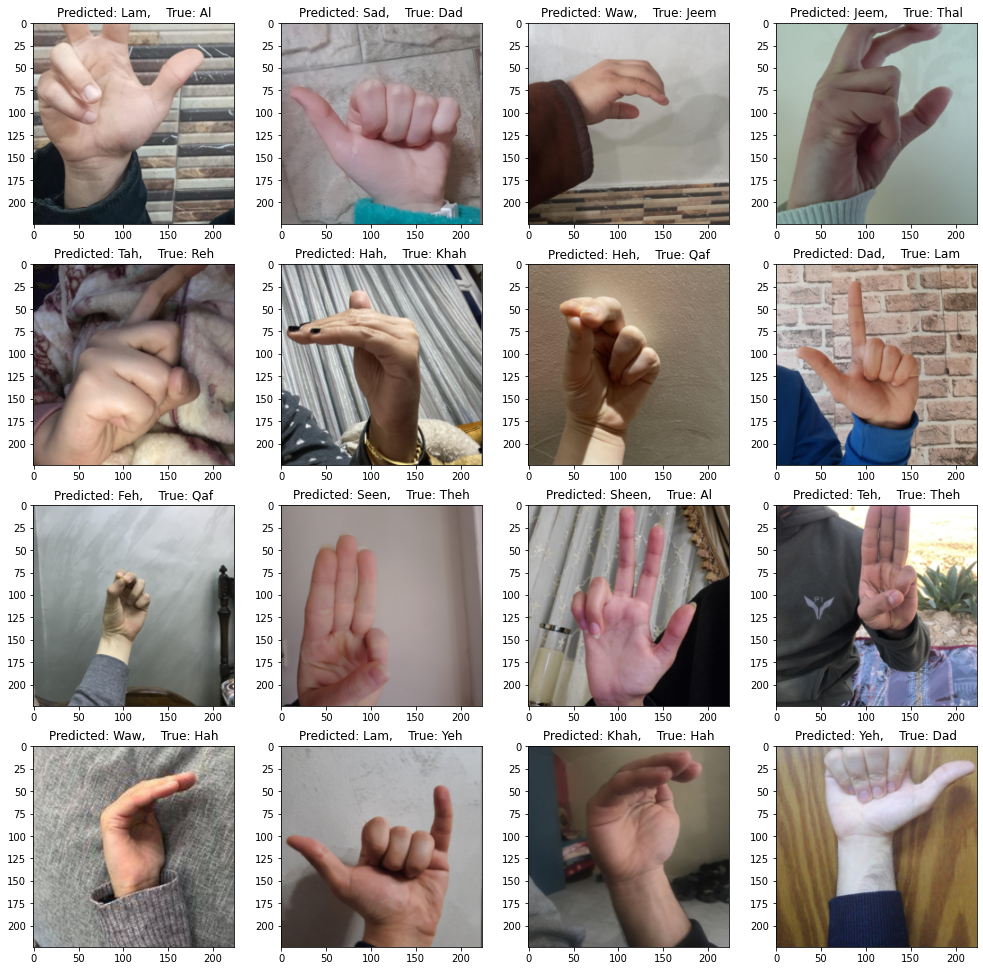

In [69]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[0:16]):
    plt.subplot(4,4,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


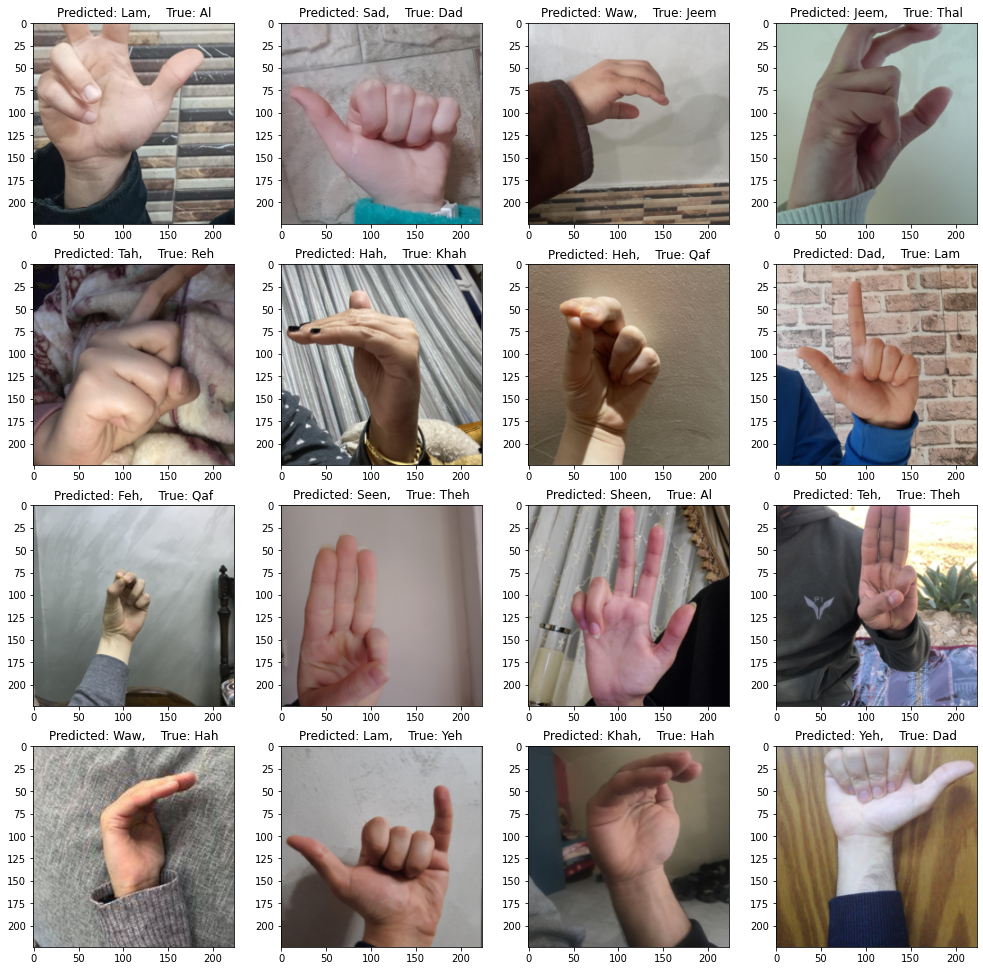

In [70]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[16:32]):
    plt.subplot(4,4,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


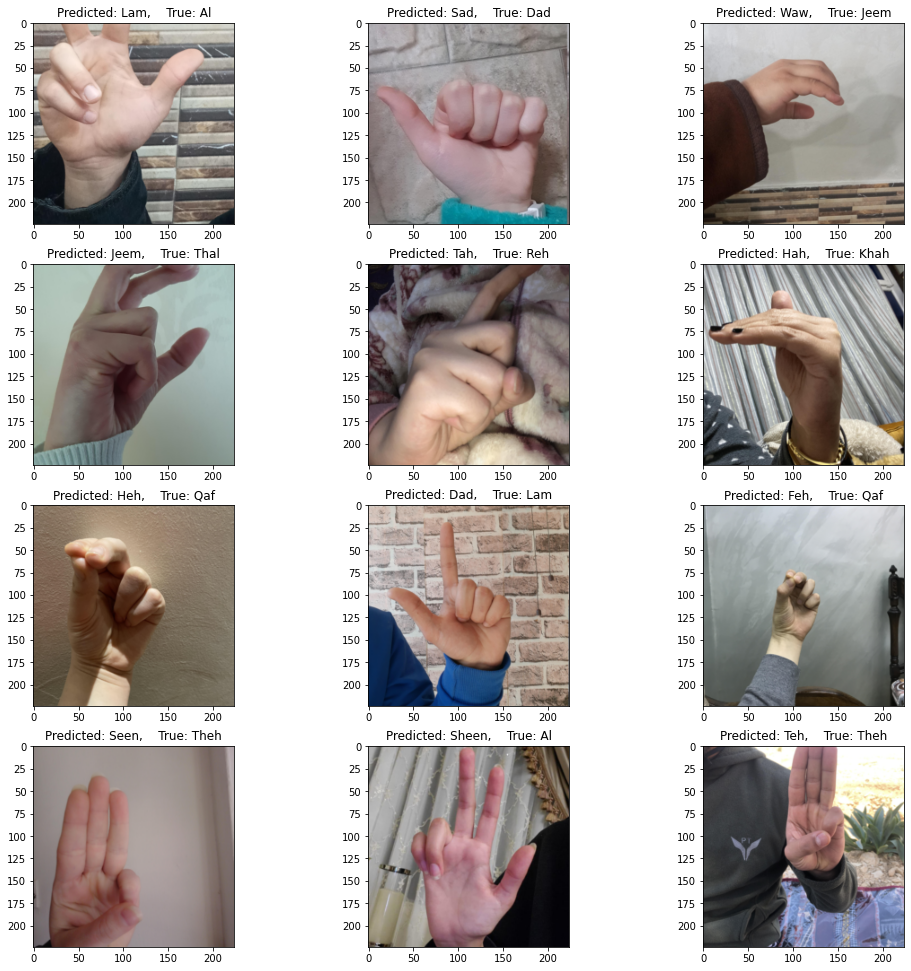

In [71]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[32:44]):
    plt.subplot(4,3,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


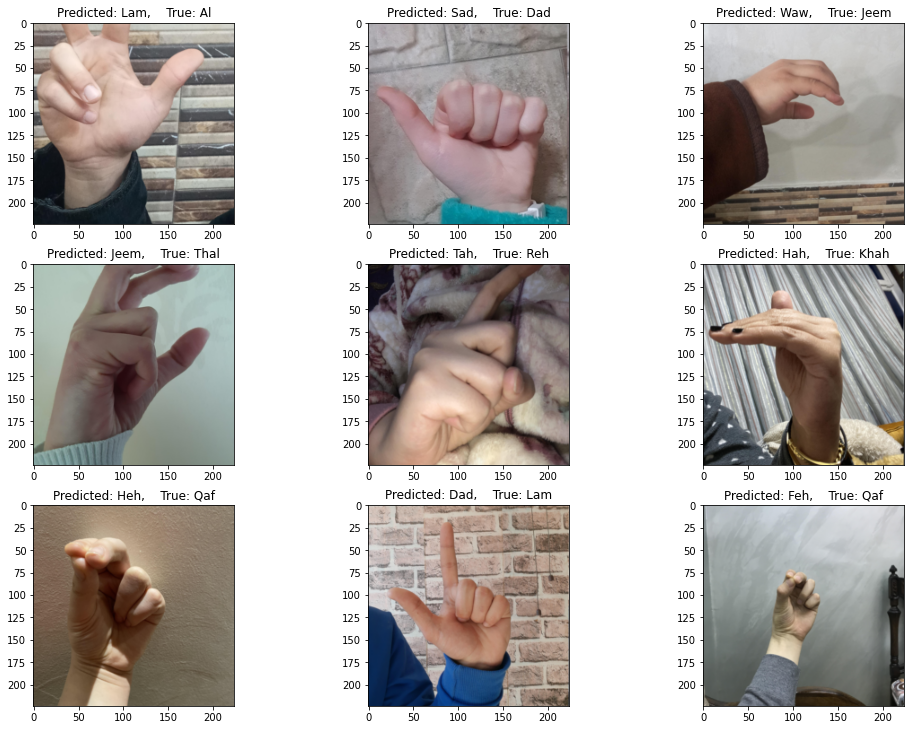

In [72]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[45:54]):
    plt.subplot(4,3,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


## Plot the confusion matrix 

In [73]:
dic_class_idx = traindataset.dataset.class_to_idx
dic_class_idx

{'Ain': 0,
 'Al': 1,
 'Alef': 2,
 'Beh': 3,
 'Dad': 4,
 'Dal': 5,
 'Feh': 6,
 'Ghain': 7,
 'Hah': 8,
 'Heh': 9,
 'Jeem': 10,
 'Kaf': 11,
 'Khah': 12,
 'Laa': 13,
 'Lam': 14,
 'Meem': 15,
 'Noon': 16,
 'Qaf': 17,
 'Reh': 18,
 'Sad': 19,
 'Seen': 20,
 'Sheen': 21,
 'Tah': 22,
 'Teh': 23,
 'Teh_Marbuta': 24,
 'Thal': 25,
 'Theh': 26,
 'Waw': 27,
 'Yeh': 28,
 'Zah': 29,
 'Zain': 30}

In [74]:
idx_to_class_dic = {v: k for k, v in dic_class_idx.items()}

In [75]:
idx_to_class_dic

{0: 'Ain',
 1: 'Al',
 2: 'Alef',
 3: 'Beh',
 4: 'Dad',
 5: 'Dal',
 6: 'Feh',
 7: 'Ghain',
 8: 'Hah',
 9: 'Heh',
 10: 'Jeem',
 11: 'Kaf',
 12: 'Khah',
 13: 'Laa',
 14: 'Lam',
 15: 'Meem',
 16: 'Noon',
 17: 'Qaf',
 18: 'Reh',
 19: 'Sad',
 20: 'Seen',
 21: 'Sheen',
 22: 'Tah',
 23: 'Teh',
 24: 'Teh_Marbuta',
 25: 'Thal',
 26: 'Theh',
 27: 'Waw',
 28: 'Yeh',
 29: 'Zah',
 30: 'Zain'}

In [76]:
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

In [77]:
label_flattened  = flatten(labels_list)
logits_flattened = flatten(logits_list)

In [78]:
cmt = torch.zeros((31,31), dtype=int)
np_arr = cmt.detach().numpy()

In [79]:
for i,_ in enumerate(label_flattened):
   tl = label_flattened[i] 
   pl = logits_flattened[i]
   np_arr[tl,pl] = np_arr[tl,pl] + 1 

In [80]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    cbar = plt.colorbar(fraction=0.0457, pad=0.04)
    cbar.ax.tick_params(labelsize=40)

    
    tick_marks = np.arange(len(classes))

                        #  {'ain'   'al': 'aleff': 'bb': 'dal' 'dha' ,'dhad'  ,'fa', 'gaaf' 'ghain'  'ha'   'haa'  'jeem' 'kaaf' 'khaa'   'la'  'laam'  'meem'  'nun'   'ra'   saad'  'seen'  'sheen'  'ta'  'taa'   'thaa'  'thal'     'toot'      'waw'   'ya': 29          'yaa'   'zay'}
    plt.xticks(tick_marks, [r'Ain',r'Al',r'Alef',r'Beh',r'Dad',r'Dal',r'Feh',r'Ghain',r'Hah', r'Heh', r'Jeem',r'Kaf',r'Khah',r'Laa',r'Lam',r'Meem',r'Noon',r'Qaf',r'Reh',r'Sad',r'Seen',r'Sheen',r'Tah',r'Teh',r'Teh_Marbuta', r'Thal',r'Theh',r'Waw',r'Yeh',r'Zah',r'Zain'],fontsize=80 , rotation=90, fontweight='bold')
    plt.yticks(tick_marks,[r'Ain',r'Al',r'Alef',r'Beh',r'Dad',r'Dal',r'Feh',r'Ghain',r'Hah',r'Heh', r'Jeem',r'Kaf',r'Khah',r'Laa',r'Lam',r'Meem',r'Noon',r'Qaf',r'Reh',r'Sad',r'Seen',r'Sheen',r'Tah',r'Teh',r'Teh_Marbuta',r'Thal', r'Theh',r'Waw',r'Yeh',r'Zah',r'Zain'] ,fontsize=80, fontweight='bold')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=35, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel(r'\bf{True label}', fontsize=40, labelpad=10,fontweight='bold')
    plt.xlabel(r'\bf{Predicted label}', fontsize=40, labelpad=10,fontweight='bold')


Confusion matrix, without normalization
[[28  0  0  0  1  2  0  0  4  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 29  0  1  0  0  0  0  0  0  0  0  0  1  4  0  1  0  0  0  0  4  0  0
   0  0  0  0  0  1  0]
 [ 0  0 39  1  1  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0  0  2  0  0  0  1  2  1  0  2  0  0  0  0  0  7
   0  0  2  0  0  0  0]
 [ 0  0  0  0 33  0  0  0  0  0  1  0  0  0  0  0  0  0  0  2  1  0  0  0
   0  0  0  0  3  0  0]
 [ 0  0  0  0  1 25  0  0  1  0  0  0  1  0  0  0  0  0  3  0  0  0  0  0
   0  4  0  0  0  0  0]
 [ 0  0  0  2  4  0 21  0  0  5  0  0  0  0  0  1  0  1  0  0  0  0  0  0
   1  0  0  1  2  0  0]
 [ 0  0  2  0  0  0  0 28  1  0  0  0  3  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 33  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  4  0  0 27  0  0  0  0  0  0  0  3  0  1  0  0  0  0
   3

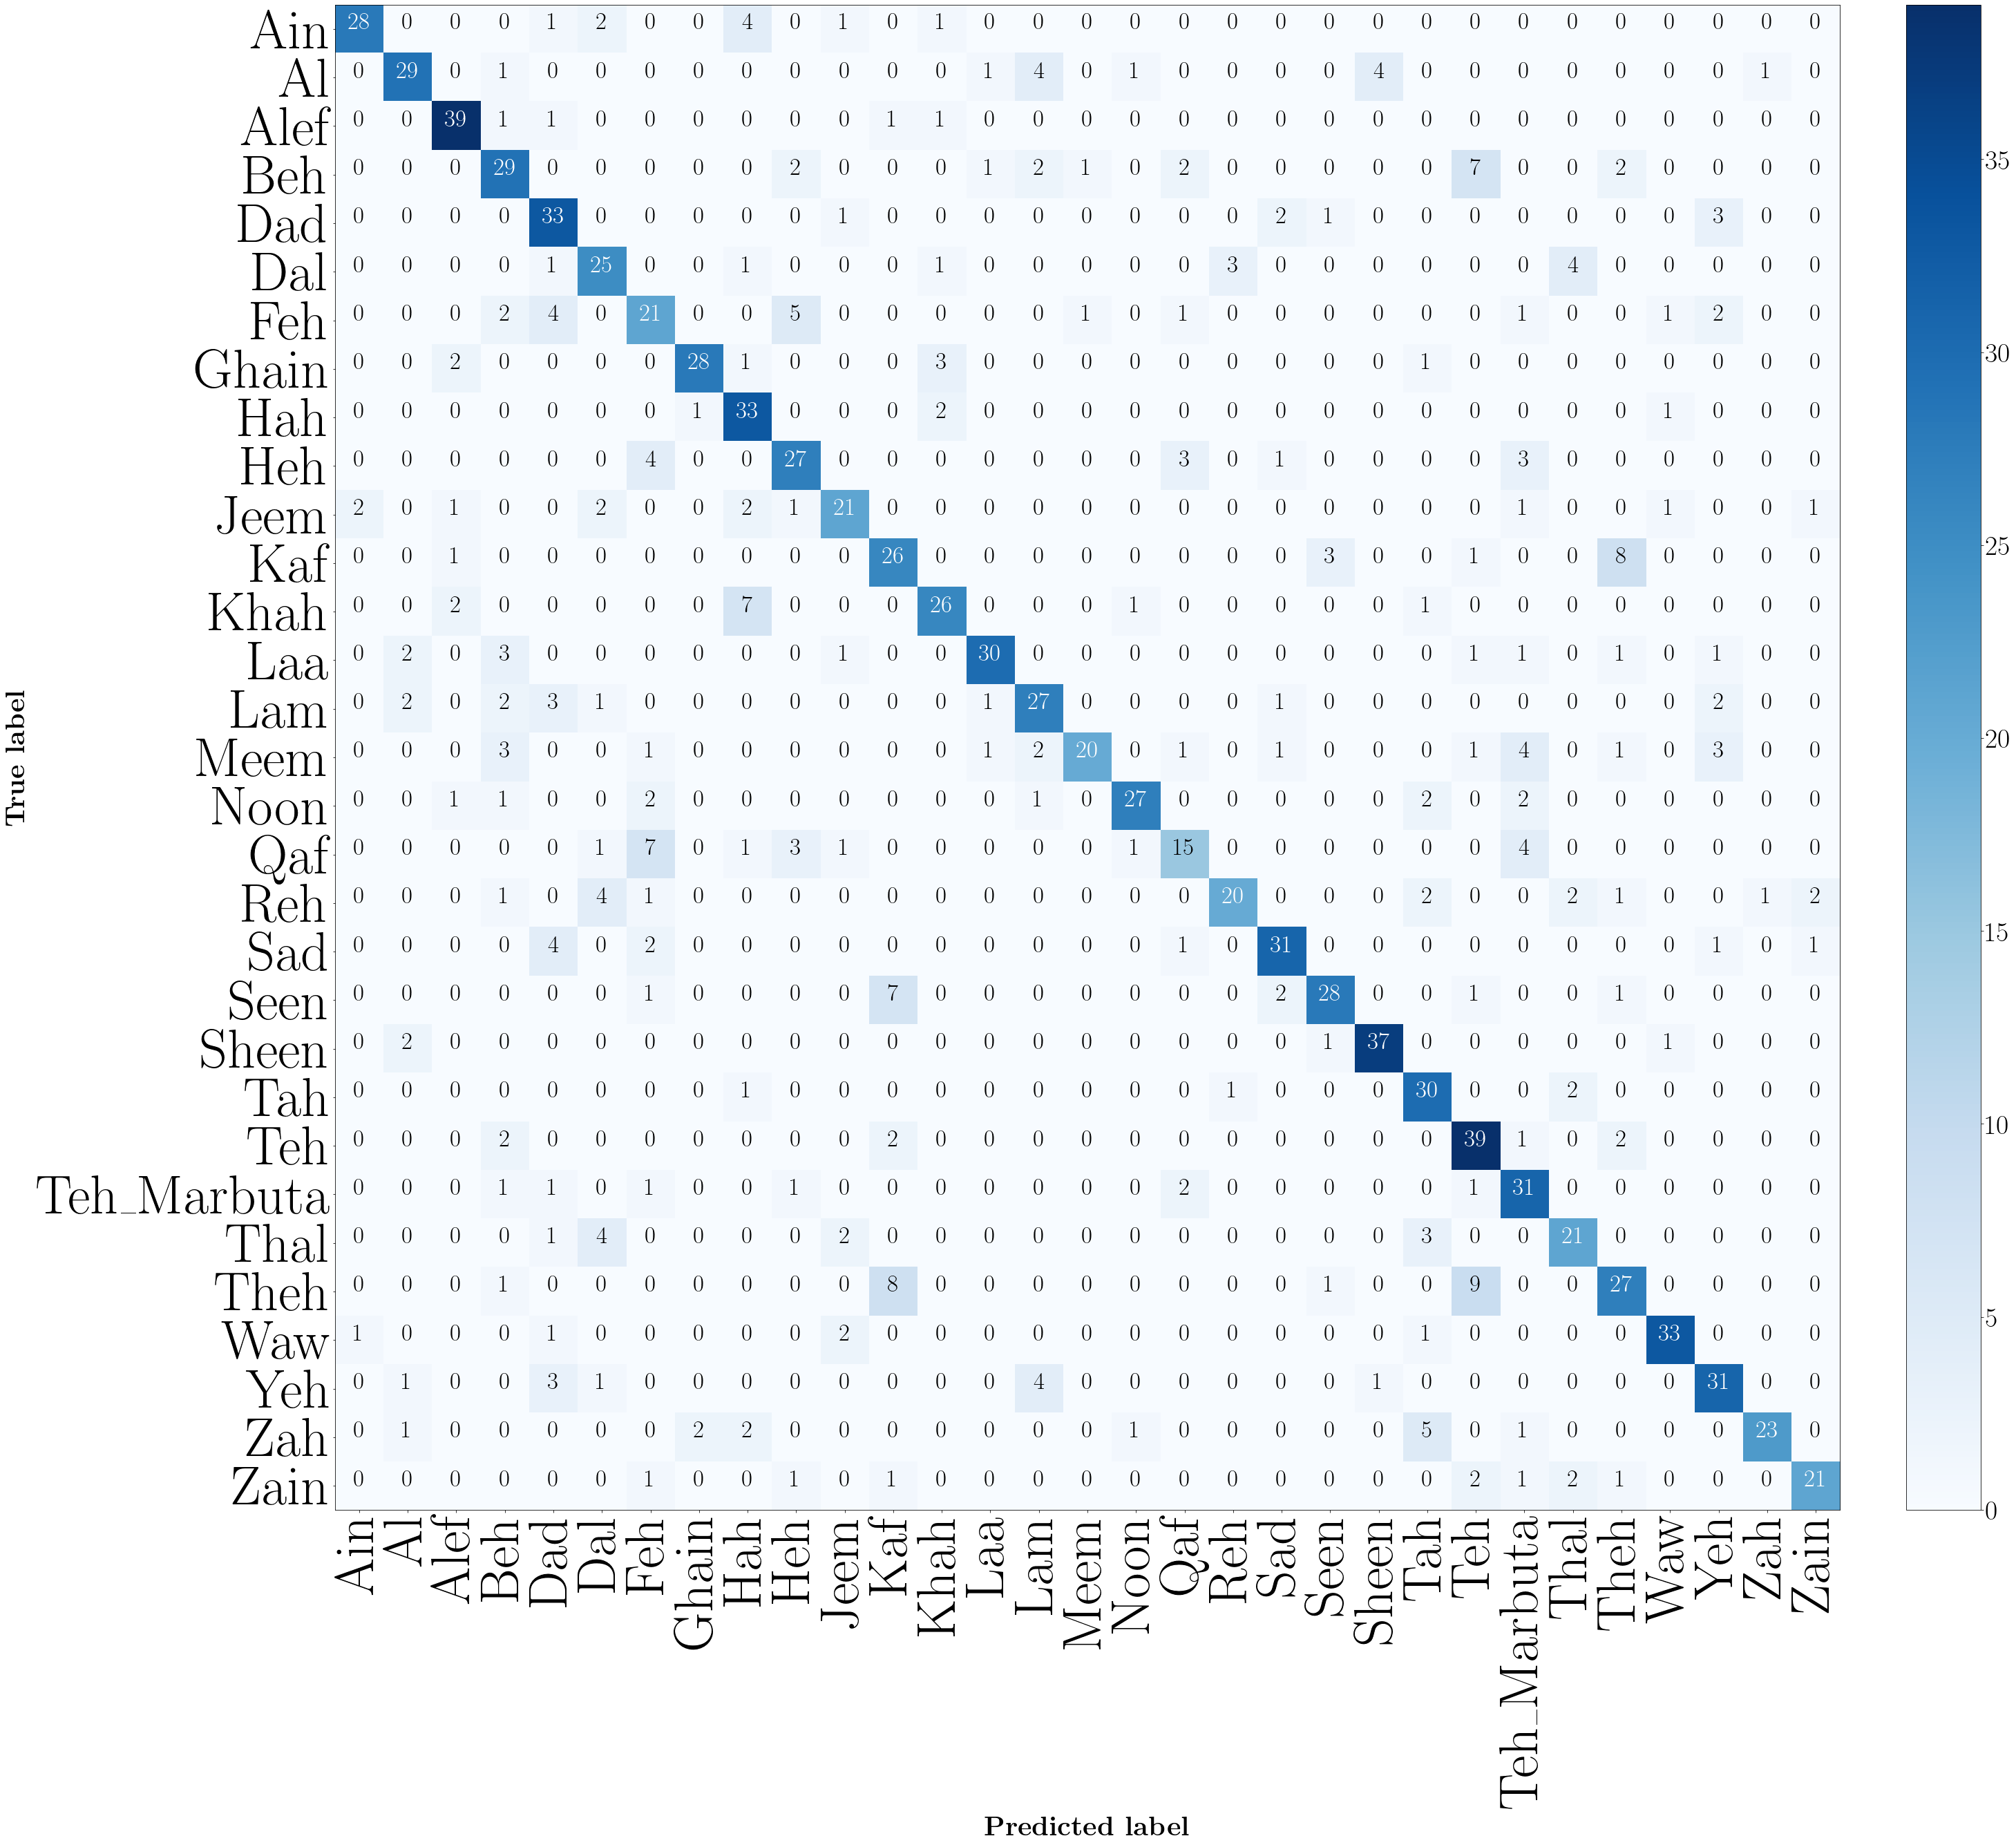

In [81]:
from sklearn.metrics import confusion_matrix
import matplotlib as mpl


plt.rcParams.update({ "text.usetex": True})


mpl.rcParams['font.family'] = 'cmu serif'
mpl.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(40,40))

plot_confusion_matrix(np_arr,dataset.classes)

print(dataset.classes)

plt.savefig(f"CM_{tensor_baord_variable}", format="pdf", dpi= 400, bbox_inches='tight')
